In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import shap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
from explainerdashboard import ExplainerDashboard, ClassifierExplainer
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import captum.attr as c
import time
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import os
from imblearn.over_sampling import SMOTE
import joblib
import import_ipynb

In [2]:
def plot_confusion_matrix(actual_labels, predicted_labels):
    """
    Plot confusion matrix with labels.
    """
    cm = confusion_matrix(actual_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [3]:
data = pd.read_csv('Cleaned_full_data.csv')
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_28360\1715623287.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [5]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Archive.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [6]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

Train: label
0    1774933
1     257104
Name: count, dtype: int64
Test label
0    443831
1     64179
Name: count, dtype: int64


In [7]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
class NNsmote(nn.Module):
    def __init__(self, n_features, fc_size, device, save_dir, name):
        super(NNsmote, self).__init__()
        self.name = name
        self.device = device
        self.save_dir = save_dir
        self.fc1 = nn.Linear(n_features, fc_size)
        self.fc2 = nn.Linear(fc_size, 1)
        self.activation1 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.to(self.device)

        self.train_loss = []
        self.train_accuracy = []
        self.train_f1 = []
        self.test_accuracy = None
        self.test_loss = None
        self.test_f1 = None
        self.test_predicted = []
        self.epoch_time = []

    def forward(self, x):
        x = self.activation1(self.fc1(x))
        x = self.fc2(x)
        return self.sigmoid(x)

    def calculate_accuracy_f1(self, predictions, labels):
        preds = (predictions > 0.5).float()
        accuracy = accuracy_score(labels.cpu(), preds.cpu())
        f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')
        return accuracy, f1

    def run(self, train_loader, criterion, optimizer, epochs, save_factor):
        for epoch in range(epochs):
            start_time = time.time()
            self.train()
            epoch_loss = 0
            epoch_accuracy = 0
            epoch_f1 = 0
            num_batches = len(train_loader)

            for _, (train_seq, train_label) in tqdm(
                enumerate(train_loader), total=num_batches, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):

                train_seq, train_label = train_seq.to(self.device), train_label.to(self.device)
                batch_size = len(train_seq)
                smote_neighbors = min(batch_size, 2)

                if batch_size > 1:
                    try:
                        smote = SMOTE(random_state=42, k_neighbors=smote_neighbors)
                        train_smote, train_label_smote = smote.fit_resample(
                            train_seq.cpu().numpy(), train_label.cpu().numpy())
                        train_smote = torch.tensor(train_smote, dtype=torch.float32).to(self.device)
                        train_label_smote = torch.tensor(train_label_smote, dtype=torch.float32).to(self.device)
                    except ValueError:
                        print('Error running SMOTE.')
                        train_smote, train_label_smote = train_seq, train_label
                else:
                    train_smote, train_label_smote = train_seq, train_label

                optimizer.zero_grad()
                outputs = self(train_smote)
                loss = criterion(outputs.squeeze(), train_label_smote)
                loss.backward()
                optimizer.step()

                acc, f1 = self.calculate_accuracy_f1(outputs, train_label_smote)
                epoch_loss += loss.item()
                epoch_accuracy += acc
                epoch_f1 += f1

            self.train_loss.append(epoch_loss / num_batches)
            self.train_accuracy.append(epoch_accuracy / num_batches)
            self.train_f1.append(epoch_f1 / num_batches)
            self.epoch_time.append(time.time() - start_time)

            print(f"Epoch [{epoch+1}/{epochs}], "
                  f"Train Loss: {self.train_loss[-1]:.4f}, Train Acc: {self.train_accuracy[-1]:.4f}, Train F1: {self.train_f1[-1]:.4f}")

            if (epoch + 1) % save_factor == 0:
                self.save_model(epoch + 1)

    def test(self, test_loader, criterion):
        self.eval()
        self.test_predicted = []
        test_loss = 0
        test_accuracy = 0
        test_f1 = 0
        num_batches = len(test_loader)

        with torch.no_grad():
            for test_seq, test_label in tqdm(test_loader, total=num_batches, desc="Testing", unit="batch"):
                test_seq, test_label = test_seq.to(self.device), test_label.to(self.device)
                test_outputs = self(test_seq)
                loss = criterion(test_outputs.squeeze(), test_label)
                accuracy, f1 = self.calculate_accuracy_f1(test_outputs, test_label)
                test_loss += loss.item()
                test_accuracy += accuracy
                test_f1 += f1
                preds = (test_outputs > 0.5).float()
                self.test_predicted.extend(preds.cpu().numpy())

        self.test_loss = test_loss / num_batches
        self.test_accuracy = test_accuracy / num_batches
        self.test_f1 = test_f1 / num_batches

        print(f"Test Loss: {self.test_loss:.4f}, Test Accuracy: {self.test_accuracy:.4f}, Test F1: {self.test_f1:.4f}")

    def save_model(self, epoch):
        path = os.path.join(self.save_dir, f"PB_epoch_{epoch}.pkl")
        joblib.dump(self, path)

    def load_model(self, path):
        model = joblib.load(path)
        model.to(model.device)
        return model

Testing: 100%|██████████| 3969/3969 [00:12<00:00, 320.69batch/s]


Test Loss: 0.6548, Test Accuracy: 0.9845, Test F1: 0.9850


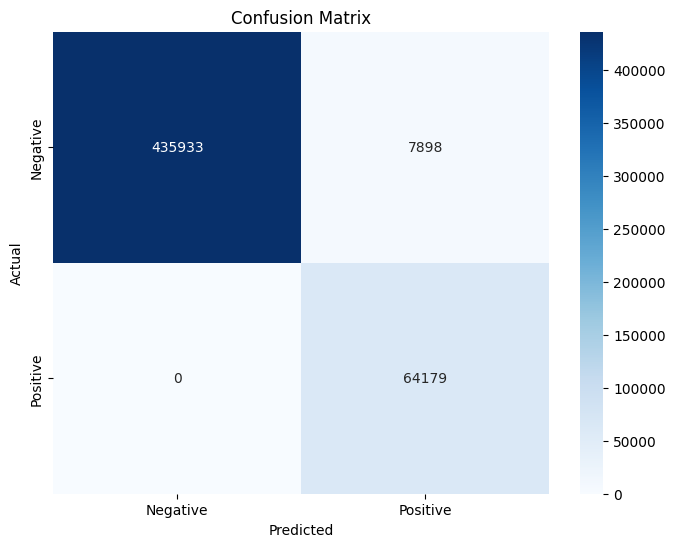

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fully_connected_size = 128
save_dir = './saved_models/'
model_name = 'PrimaryBinary'
model1 = NNsmote(n_features=n_features, fc_size=fully_connected_size, device=device, save_dir=save_dir, name=model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = './Models_Final/saved_models/PB_epoch_1.pkl'
model = joblib.load(path)
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.BCEWithLogitsLoss()
model = model1.load_model(path)
model.test(test_loader, criterion)
y_pred = np.array(model.test_predicted)
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model.test_predicted)

In [14]:
print(len(test_dataset.tensors[0]))
print(len(y_pred[y_pred==1]))

508010
72077


In [15]:
rf = joblib.load('./Models_Final/saved_models/SecondaryMulti.joblib')
label_encoder = joblib.load('./Models_Final/saved_models/label_encoder.joblib')

In [20]:
data2 = pd.DataFrame(test_dataset.tensors[0], columns=X_test.columns)
data2['y_pred'] = y_pred
data2['actual'] = test_attack_cat.reset_index(drop=True)

In [ ]:
print(test_attack_cat.value_counts(dropna=False))
print(data2['actual'].value_counts(dropna=False))
data2 = data2[data2['y_pred'] == 1]
data2 = data2.reset_index(drop=True)
print(data2['actual'].value_counts(dropna=False))

In [24]:
actual = label_encoder.transform(data2['actual'])
data2 = data2.drop(columns=['y_pred', 'actual'])
print(len(data2))

72077


In [25]:
y_pred = rf.predict(data2)
print('\nClassification Report (Test Set):')
print(classification_report(actual, y_pred))
print(y_pred)


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.69      0.08      0.14       550
           1       0.74      0.06      0.12       477
           2       0.30      0.22      0.26      3315
           3       0.61      0.82      0.70      8732
           4       0.79      0.70      0.74      4784
           5       1.00      0.98      0.99     43110
           6       0.88      0.93      0.90      7898
           7       0.94      0.77      0.85      2850
           8       0.69      0.77      0.73       320
           9       0.33      0.02      0.05        41

    accuracy                           0.88     72077
   macro avg       0.70      0.54      0.55     72077
weighted avg       0.88      0.88      0.88     72077

[5 3 3 ... 2 3 5]


In [26]:
y_pred_decoded = label_encoder.inverse_transform(y_pred)
actual_decoded = label_encoder.inverse_transform(actual)
print('\nClassification Report (Test Set):')
print(classification_report(actual_decoded, y_pred_decoded))
categories = label_encoder.classes_
for category in categories:
    actual_category = actual_decoded == category
    predicted_category = y_pred_decoded == category
    accuracy = (actual_category & predicted_category).sum() / actual_category.sum()
    print(f"Accuracy for category '{category}': {accuracy:.4f}")


Classification Report (Test Set):
                precision    recall  f1-score   support

      Analysis       0.69      0.08      0.14       550
      Backdoor       0.74      0.06      0.12       477
           DoS       0.30      0.22      0.26      3315
      Exploits       0.61      0.82      0.70      8732
       Fuzzers       0.79      0.70      0.74      4784
       Generic       1.00      0.98      0.99     43110
        Normal       0.88      0.93      0.90      7898
Reconnaissance       0.94      0.77      0.85      2850
     Shellcode       0.69      0.77      0.73       320
         Worms       0.33      0.02      0.05        41

      accuracy                           0.88     72077
     macro avg       0.70      0.54      0.55     72077
  weighted avg       0.88      0.88      0.88     72077

Accuracy for category 'Analysis': 0.0800
Accuracy for category 'Backdoor': 0.0650
Accuracy for category 'DoS': 0.2244
Accuracy for category 'Exploits': 0.8221
Accuracy for catego

In [41]:
actual_normal = actual_decoded[actual_decoded == 'Normal']
predicted_normal = y_pred_decoded[y_pred_decoded == 'Normal']
print(f"Wrong Predictions: {predicted_normal.shape[0] - actual_normal.shape[0]}")

Wrong Predictions: 447
